<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-3)" data-toc-modified-id="Общее-впечатление-(ревью-3)-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 3)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-Регрессия" data-toc-modified-id="Линейная-Регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная Регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-итог" data-toc-modified-id="Общий-итог-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий итог</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [27]:
#подключение необходимых библиотек
import pandas as pd
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
#открытие данных
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Видно, что в данных информация в промежутке 2018-03-01 00:00:00 до 2018-08-31 23:50:00

## Анализ

Text(0, 0.5, 'Количество заказов')

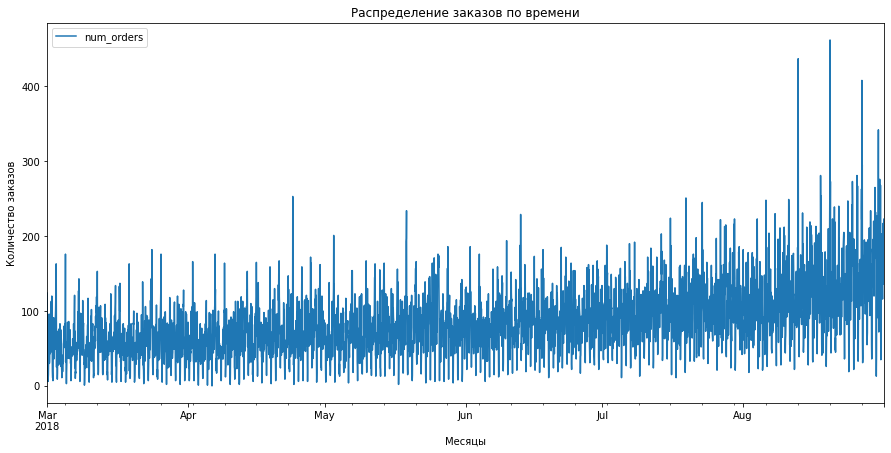

In [3]:
#ресемплирование данных
data = data.resample('1H').sum()
#посмотрим на данные с помощью графика
data.plot(figsize=(15,7))
plt.title('Распределение заказов по времени')
plt.xlabel("Месяцы")
plt.ylabel('Количество заказов')

Данных слишком много. Посмотрим на более узкий период.

Text(0, 0.5, 'Количество заказов')

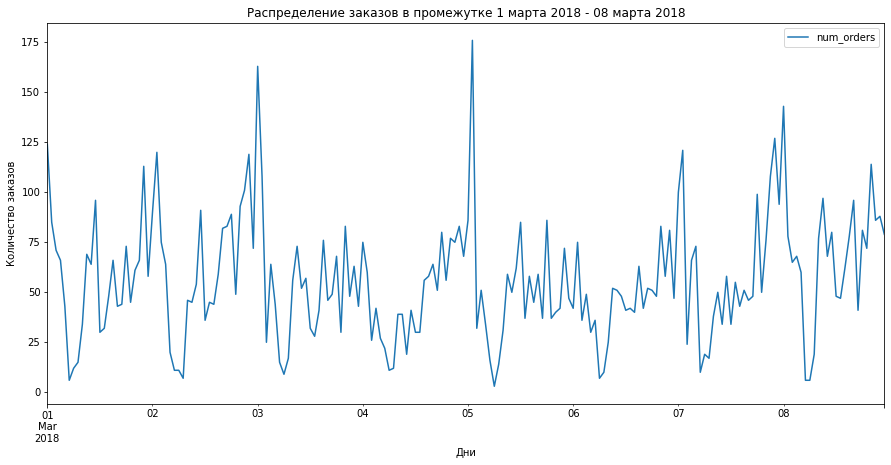

In [4]:
data['2018-03-01':'2018-03-08'].plot(figsize=(15,7))
plt.title('Распределение заказов в промежутке 1 марта 2018 - 08 марта 2018')
plt.xlabel("Дни")
plt.ylabel('Количество заказов')

* Наблюдается изменение количества заказов в течение недели и дня. Пик заказок приходится на начало и середину недели, а после количество заказов падает.

Необходимо провести декомпозицию для определения наличия тренда и сезонности.

Text(0, 0.5, 'Количество заказов')

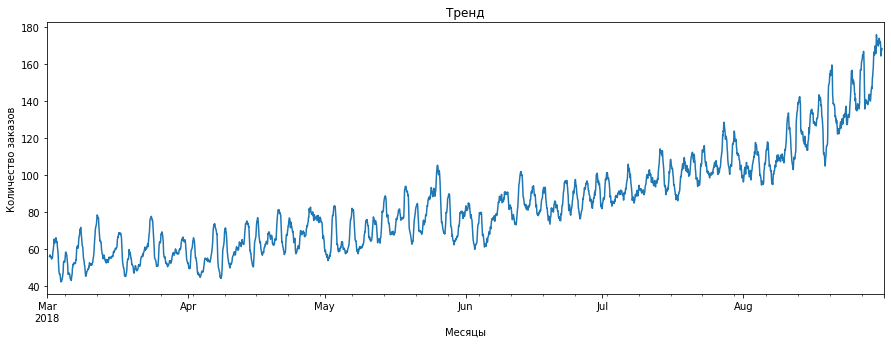

In [5]:
#декомпозиция
decomposed = seasonal_decompose(data)
decomposed.trend.plot(title='Тренд', figsize=(15,5))
plt.xlabel("Месяцы")
plt.ylabel('Количество заказов')

* Наблюдается увеличение заказов с каждым месяцем

Text(0, 0.5, 'Количество заказов')

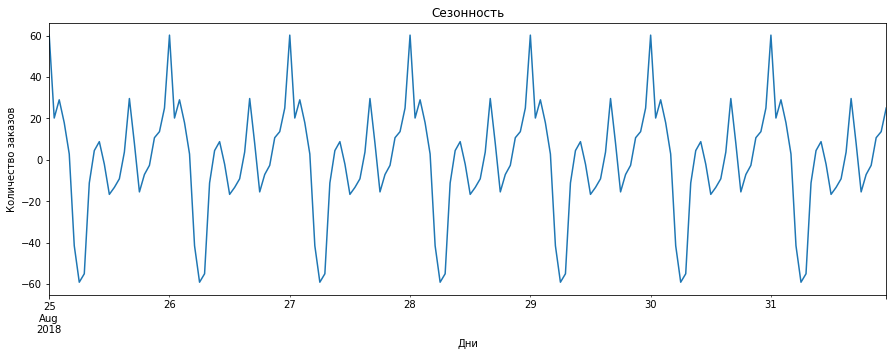

In [6]:
decomposed.seasonal.tail(24*7).plot(title='Сезонность', figsize=(15,5))
plt.xlabel("Дни")
plt.ylabel('Количество заказов')

* На графиках виден тренд и сезонность.

Есть ли сезонность в течение дня, посмотрим.

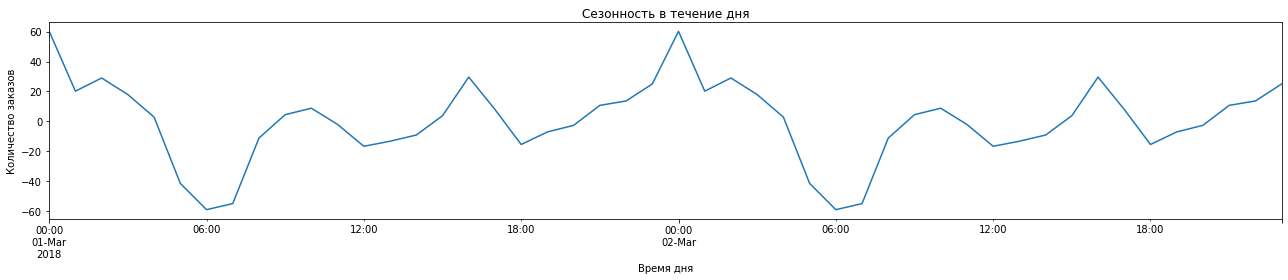

In [7]:
plt.figure(figsize=(18, 4))
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Сезонность в течение дня')
plt.xlabel("Время дня")
plt.ylabel('Количество заказов')
plt.tight_layout()

По графику наблюдается снижение заказов к 6 утра, а пик приходится на 12 часов ночи.

**Вывод:**

* Наблюдается изменение количества заказов в течение недели и дня. Пик заказок приходится на начало и середину недели, а после количество заказов падает.
* Наблюдается рост заказов от месяца к месяцу
* Наблюдается в течение дня снижение заказов к 6 утра, а пик приходится на 12 часов ночи
* Временной ряд не является стационарным так как есть тренд

## Обучение

Создадим с помощью функции следующие признаки:
* час
* день
* месяц
* день недели
* скользящее среднее

In [8]:
#создание признаков с помощью функции
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [9]:
#обращение к функции
make_features(data, 10, 10)

In [10]:
#просмотр данных
data.head()

,num_orders,hour,day,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,10,1,3,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,11,1,3,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,12,1,3,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,13,1,3,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,14,1,3,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


Подготовим данные к обучению и разделим на выборки.

In [11]:
#разделение на выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [12]:
#проверка данных
print('Обучающая:', train.index.min(), train.index.max(), train.shape)
print('Тестовая:', test.index.min(), test.index.max(), test.shape)

Обучающая: 2018-03-01 10:00:00 2018-08-13 14:00:00 (3965, 16)
Тестовая: 2018-08-13 15:00:00 2018-08-31 23:00:00 (441, 16)


Приступим к поиску наилучших параметров, при которых на обучающей выборке будет достигнут наименьший RMSE.

### Линейная Регрессия

In [13]:
tscv = TimeSeriesSplit(n_splits=5)

In [14]:
linear_par = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [15]:
%%time
model_linear = LinearRegression()
grid_linear = GridSearchCV(model_linear, param_grid = linear_par, refit=False, 
                       scoring='neg_root_mean_squared_error', cv=tscv)
grid_linear.fit(features_train, target_train)
print(f'Лучшая RMSE: {-grid_linear.best_score_} при параметрах {grid_linear.best_params_}')

Лучшая RMSE: 31.500657020013836 при параметрах {'copy_X': True, 'fit_intercept': False, 'normalize': True}
CPU times: user 1.63 s, sys: 2.45 s, total: 4.09 s
Wall time: 4.08 s


**Вывод:**
* Лучшие параметры:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}
* RMSE на обучающей выборке:  31.500657020013836
* Wall time: 4.63 s

### Случайный лес

In [16]:
random=12345
forest_par = {'n_estimators' : range(50, 101, 10), 'max_depth' : range(5, 15, 2), 'verbose' : [0],
        'random_state' : [random] }

In [17]:
%%time
model_forest=RandomForestRegressor()
grid_forest = GridSearchCV(model_forest, param_grid = forest_par, refit=False, 
                      scoring='neg_root_mean_squared_error', cv=tscv)
grid_forest.fit(features_train, target_train)
print(f'Лучшая RMSE: {-grid_forest.best_score_} при параметрах {grid_forest.best_params_}')

Лучшая RMSE: 25.289669842399235 при параметрах {'max_depth': 13, 'n_estimators': 70, 'random_state': 12345, 'verbose': 0}
CPU times: user 1min 45s, sys: 454 ms, total: 1min 45s
Wall time: 1min 45s


**Вывод:**
* Лучшие параметры:  {'max_depth': 13, 'n_estimators': 70, 'random_state': 12345, 'verbose': 0}
* RMSE на обучающей выборке:  25.289669842399235
* Wall time: 1min 56s

### LGBM

In [18]:
%%time
model_lgbm=LGBMRegressor()
par = [{'learning_rate':[x/10 for x in range(1, 6)], 'random_state':[random]}]
grid_lgbm = GridSearchCV(model_lgbm, par, scoring='neg_root_mean_squared_error', cv=tscv)
grid_lgbm.fit(features_train, target_train)
print(f'Лучшая RMSE: {-grid_lgbm.best_score_} при параметрах {grid_lgbm.best_params_}')

Лучшая RMSE: 25.181178927102604 при параметрах {'learning_rate': 0.1, 'random_state': 12345}
CPU times: user 12min 31s, sys: 19.9 s, total: 12min 51s
Wall time: 12min 58s


**Вывод:**
* Лучшие параметры:  {'learning_rate': 0.1, 'random_state': 12345}
* RMSE на обучающей выборке:  25.181178927102604
* Wall time: 12min 58s

Cравним RMSE, проведя кроссвалидацию на обучающей выборке по каждой из рассматриваемых моделей:

In [29]:
RMSE_linear = -cross_val_score(model_linear, features_train, target_train, scoring='neg_root_mean_squared_error',
                               cv=tscv).mean()
RMSE_forest = -cross_val_score(model_forest, features_train, target_train, scoring='neg_root_mean_squared_error', 
                               cv=tscv).mean()
RMSE_lgbm = -cross_val_score(model_lgbm, features_train, target_train, scoring='neg_root_mean_squared_error',
                             cv=tscv).mean()
print("Линейная регрессия: ", RMSE_linear, '\n')
print("Случайный лес: ", RMSE_forest, '\n')
print("LGBM: ", RMSE_lgbm)

Линейная регрессия:  31.502385927381134 

Случайный лес:  25.278367100454233 

LGBM:  25.181178927102604


Минимальное значение метрики у модели, обученной методом **LightGBM с результатом RMSE = 25.181178927102604.**

## Тестирование

Теперь протестируем лучшую модель на тестовой выборке и посмотрим на результат.

In [30]:
#предсказания на тестовой выбоке
model = LGBMRegressor(learning_rate=0.1, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, predictions)**0.5)

RMSE на тестовой выборке:  43.57031483988515


### Вывод

Лучшая модель LGBM с гиперпараметрами: learning_rate': 0.1, 'random_state': 12345, RMSE на тестовой выборке:  43.57031483988515

## Общий итог

* Был произведен анализ данных и обнаружены следущие моменты:
    * Наблюдается изменение количества заказов в течение недели и дня. Пик заказок приходится на начало и середину недели, а после количество заказов падает.
    * Наблюдается рост заказов от месяца к месяцу
    * Наблюдается в течение дня снижение заказов к 6 утра, а пик приходится на 12 часов ночи
    * Временной ряд не является стационарным так как есть тренд
* После были обучены 3 модели и был произведен подбор наилучших гиперпараметров со следующими результатами:

    * Линейная регрессия:

       * Лучшие параметры:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}
        * RMSE на обучающей выборке:  31.500657020013836
        * Wall time: 4.63 s

    * Случайный лес

        * Лучшие параметры:  {'max_depth': 13, 'n_estimators': 70, 'random_state': 12345, 'verbose': 0}
        * RMSE на обучающей выборке:  25.289669842399235
        * Wall time: 1min 56s

    * LGBM

        * Лучшие параметры:  {'learning_rate': 0.1, 'random_state': 12345}
        * RMSE на обучающей выборке:  25.181178927102604
        * Wall time: 12min 58s

* С помощью кросс-валидации была найдена модель с наименьшей метрикой. Лучшие показатели у **LGBM** с гиперпараметрами:**learning_rate': 0.1, 'random_state': 12345**. Она и было проверена на тестовой выборке. Были получены следующие результаты: **RMSE = 43.57031483988515.**